In [1]:
# Load libraries
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import decomposition, preprocessing, svm 

import seaborn as sns
sns.set_style('darkgrid')
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import mean_absolute_error
from sklearn.externals import joblib

In [2]:
# Load dataset
prostate_data = pd.read_csv("data//prostate_cancer.csv")
prostate_data.tail()

,id,diagnosis_result,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
95,96,M,23,16,132,1264,0.091,0.131,0.210,0.056
96,97,B,22,14,78,451,0.105,0.071,0.190,0.066
97,98,B,19,27,62,295,0.102,0.053,0.135,0.069
98,99,B,21,24,74,413,0.090,0.075,0.162,0.066
99,100,M,16,27,94,643,0.098,0.114,0.188,0.064


In [3]:
# Delete the id columns
del prostate_data['id']

In [4]:
# Shape 
print(prostate_data.shape)

(100, 9)


In [5]:
prostate_data = prostate_data.replace({'diagnosis_result' : { 'M' : 1, 'B' : 0}})
# prostate_data

In [6]:
# Statistical description
prostate_data.describe()

# From this, can tell that there is no missing data

,diagnosis_result,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.620000,16.850000,18.230000,96.780000,702.880000,0.102730,0.126700,0.193170,0.064690
std,0.487832,4.879094,5.192954,23.676089,319.710895,0.014642,0.061144,0.030785,0.008151
min,0.000000,9.000000,11.000000,52.000000,202.000000,0.070000,0.038000,0.135000,0.053000
25%,0.000000,12.000000,14.000000,82.500000,476.750000,0.093500,0.080500,0.172000,0.059000
50%,1.000000,17.000000,17.500000,94.000000,644.000000,0.102000,0.118500,0.190000,0.063000
75%,1.000000,21.000000,22.250000,114.250000,917.000000,0.112000,0.157000,0.209000,0.069000
max,1.000000,25.000000,27.000000,172.000000,1878.000000,0.143000,0.345000,0.304000,0.097000


In [7]:
# Class distribution to see how many are prone to heart attacks by the 'num' feature
print(prostate_data.groupby('diagnosis_result').size())

diagnosis_result
0    38
1    62
dtype: int64


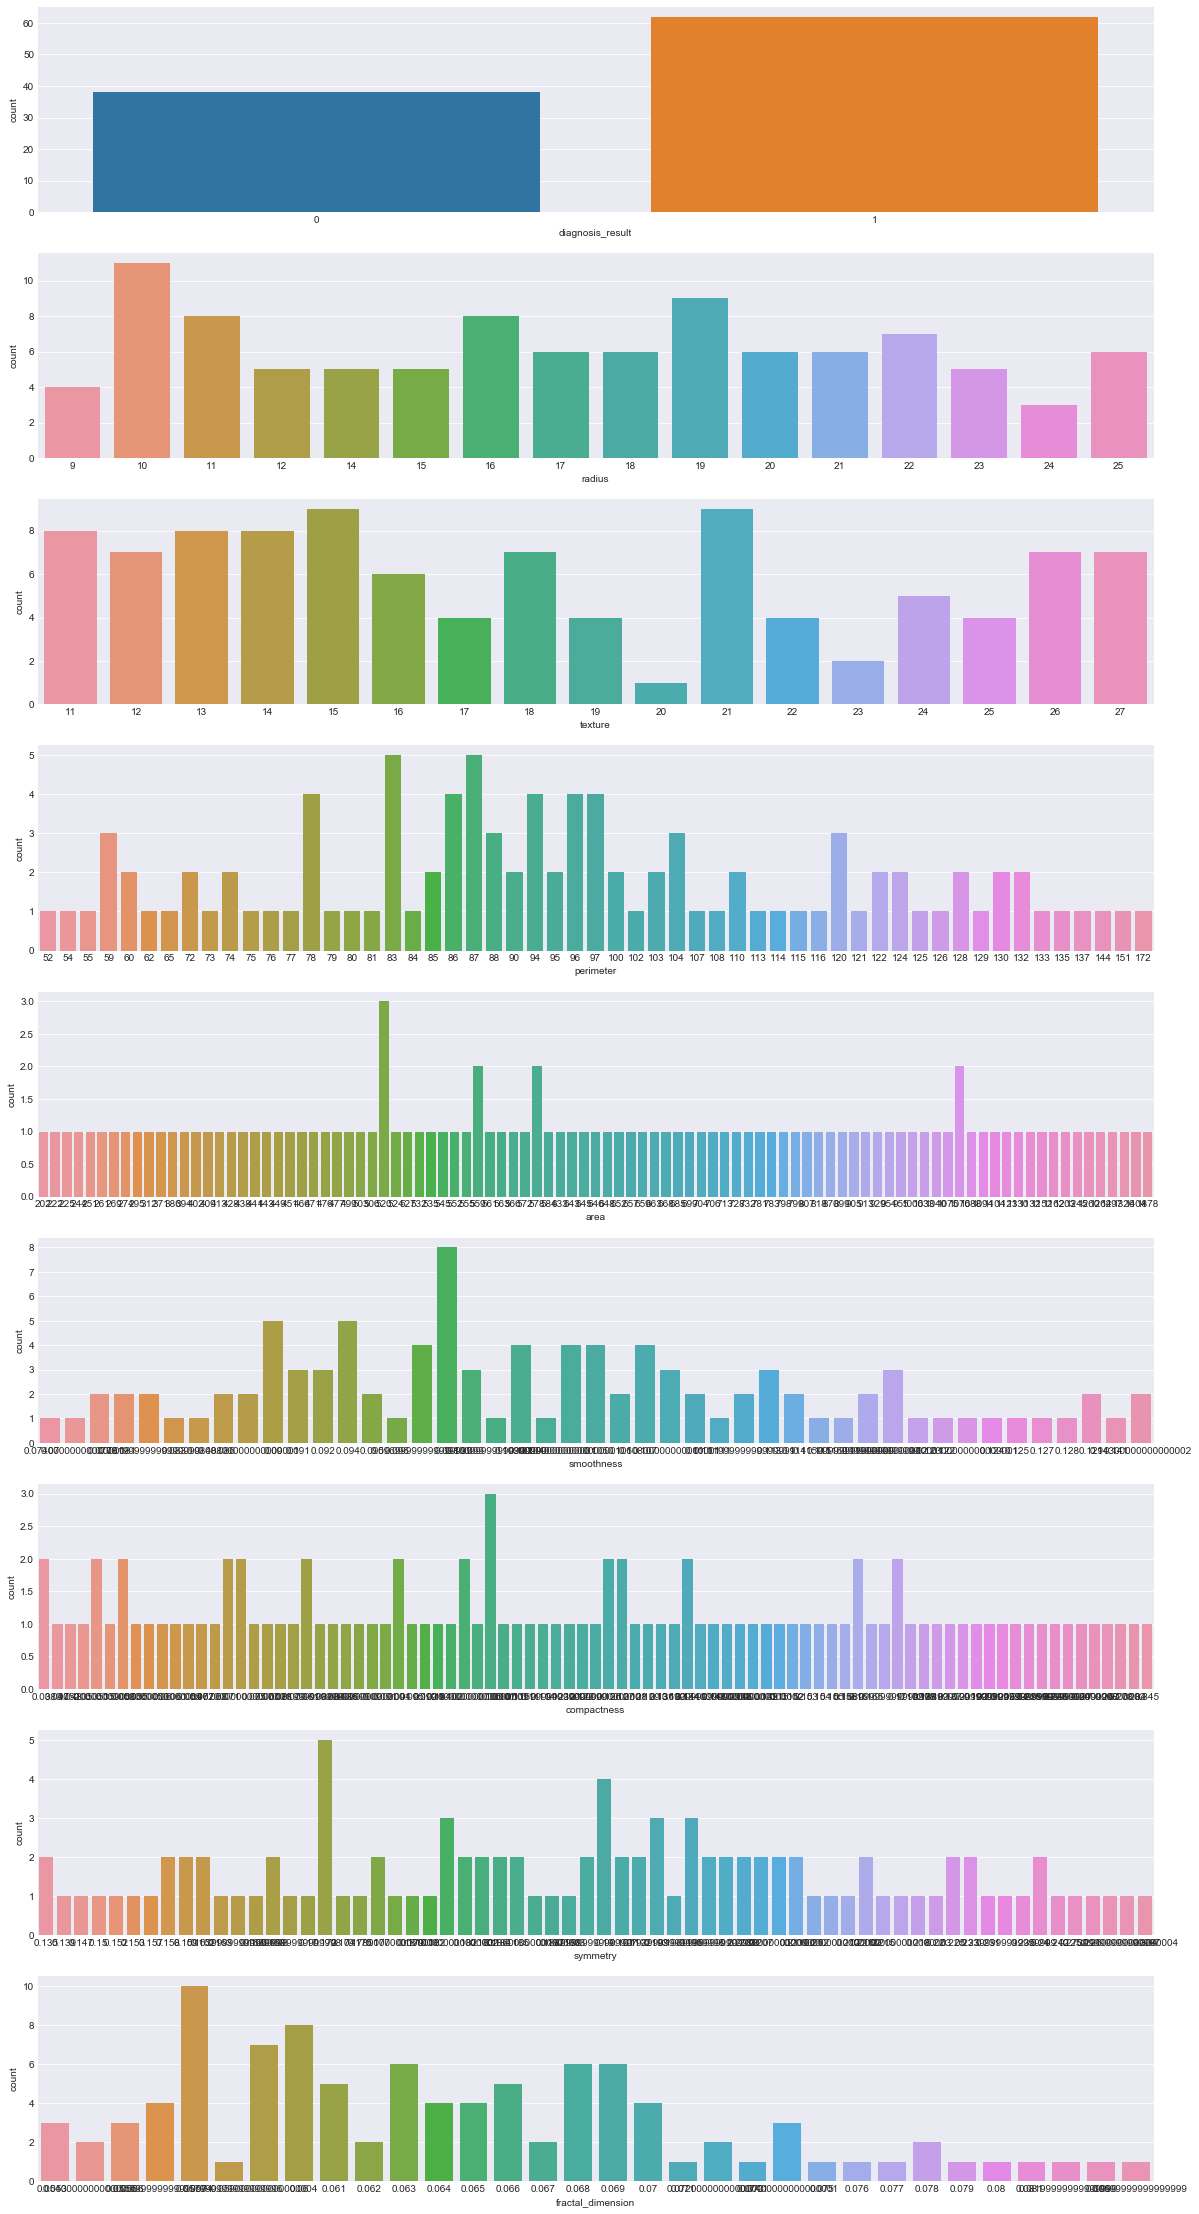

In [8]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9) = plt.subplots(9,1,figsize=(20,40))
sns.countplot(x='diagnosis_result', data=prostate_data, ax=ax1)
sns.countplot(x='radius', data=prostate_data, ax=ax2)
sns.countplot(x='texture', data=prostate_data, ax=ax3)
sns.countplot(x='perimeter', data=prostate_data, ax=ax4)
sns.countplot(x='area', data=prostate_data, ax=ax5)
sns.countplot(x='smoothness', data=prostate_data, ax=ax6)
sns.countplot(x='compactness', data=prostate_data, ax=ax7)
sns.countplot(x='symmetry', data=prostate_data, ax=ax8)
sns.countplot(x='fractal_dimension', data=prostate_data, ax=ax9)

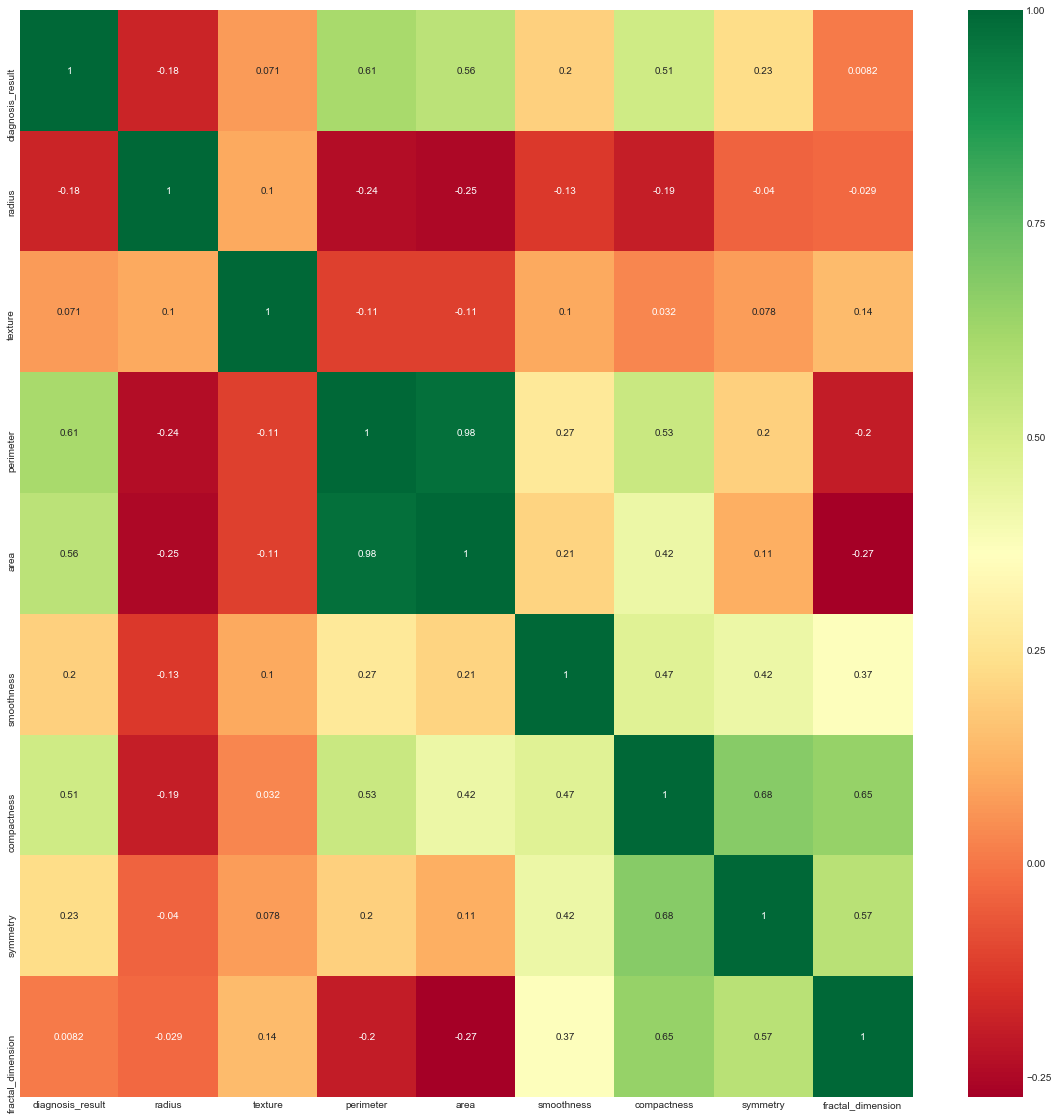

In [9]:
# Features
X = prostate_data.iloc[:,1:8]  
# Classes / target
y = prostate_data.iloc[:,0] 
   
# Get correlations of each features in dataset
corrmat = prostate_data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))

# Plot heat map
g=sns.heatmap(prostate_data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# First row i.e diagnosis_result, 
# diagnosis_result is correlated with other features, 
# the features with the least correlation are:
# -- fractal_dimension (0.0082) 
# -- texture (0.071)
# I will delete these columns

# 'area' and 'perimeter' seem to be highly correlated - these lead to decreased generalization performance on the test set due to high variance and less model interpretability.
# I will delete 'area' since it has a lower correlation to the target variable

In [10]:
del prostate_data['fractal_dimension']
del prostate_data['texture']
del prostate_data['area']

In [11]:
#Shuffle the data 
np.random.seed(18)
prostate_data_shuffle = prostate_data.iloc[np.random.permutation(len(prostate_data))]

In [12]:
prostate_data_shuffle.columns

Index(['diagnosis_result', 'radius', 'perimeter', 'smoothness', 'compactness',
       'symmetry'],
      dtype='object')

In [13]:
# Convert the Pandas dataframes into numpy arrays that can be used by scikit_learn
all_data = prostate_data_shuffle[['diagnosis_result', 'radius', 'perimeter', 'smoothness','compactness', 'symmetry']].values

# Create array of only the feature data 
features = prostate_data_shuffle[['radius', 'perimeter', 'smoothness','compactness', 'symmetry']].values

# Separate array to contain target
results = prostate_data_shuffle['diagnosis_result'].values

# Also need array of the feature names - this will help later when exploring the data
feature_names = ['radius', 'perimeter', 'smoothness','compactness', 'symmetry']

# print the features array of feature data
features

array([[1.40e+01, 1.20e+02, 1.15e-01, 1.49e-01, 2.09e-01],
       [2.00e+01, 8.60e+01, 1.16e-01, 1.23e-01, 2.13e-01],
       [1.50e+01, 8.70e+01, 1.04e-01, 1.44e-01, 1.97e-01],
       [1.80e+01, 9.70e+01, 9.10e-02, 7.10e-02, 1.62e-01],
       [1.10e+01, 1.28e+02, 9.40e-02, 1.72e-01, 1.85e-01],
       [2.00e+01, 7.80e+01, 1.03e-01, 9.10e-02, 1.68e-01],
       [2.30e+01, 1.51e+02, 1.43e-01, 2.78e-01, 2.42e-01],
       [1.40e+01, 1.32e+02, 9.70e-02, 2.46e-01, 2.40e-01],
       [1.00e+01, 8.50e+01, 9.70e-02, 1.05e-01, 1.75e-01],
       [1.00e+01, 1.00e+02, 9.20e-02, 1.04e-01, 1.72e-01],
       [2.10e+01, 1.30e+02, 1.25e-01, 1.60e-01, 2.07e-01],
       [2.30e+01, 1.32e+02, 9.10e-02, 1.31e-01, 2.10e-01],
       [1.00e+01, 8.80e+01, 1.29e-01, 1.05e-01, 2.40e-01],
       [9.00e+00, 1.33e+02, 1.43e-01, 7.90e-02, 1.81e-01],
       [1.80e+01, 7.90e+01, 9.20e-02, 6.80e-02, 1.72e-01],
       [9.00e+00, 1.35e+02, 1.41e-01, 1.33e-01, 1.81e-01],
       [1.90e+01, 1.22e+02, 9.00e-02, 1.21e-01, 1.95e-01

In [14]:
# Save the new heart attack data csv
df = pd.DataFrame(all_data, columns = ['diagnosis_result', 'radius', 'perimeter', 'smoothness','compactness', 'symmetry'])

df.to_csv('new_prostate_cancer.csv')

In [15]:
# Normalize the attribute data using preprocessing.StandardScaler() 
# Normalization means adjusting values measured on different scales to a common scale
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
features_scaled = scaler.fit_transform(features)
features_scaled

# scaler has calculated the mean and scaling factor to standardize each feature

array([[-0.58706759,  0.98567709,  0.84223621,  0.36655278,  0.51680141],
       [ 0.64886417, -0.45760547,  0.91087812, -0.06081817,  0.64738926],
       [-0.38107896, -0.41515598,  0.08717522,  0.28436606,  0.12503786],
       [ 0.23688692,  0.00933889, -0.80516958, -0.91556009, -1.0176058 ],
       [-1.20503347,  1.32527298, -0.59924386,  0.7446117 , -0.26672568],
       [ 0.64886417, -0.79720137,  0.01853332, -0.5868132 , -0.82172403],
       [ 1.26683005,  2.30161118,  2.76420965,  2.48697022,  1.59415115],
       [-0.58706759,  1.49507093, -0.39331813,  1.9609752 ,  1.52885723],
       [-1.41102209, -0.50005496, -0.39331813, -0.35669038, -0.5931953 ],
       [-1.41102209,  0.13668735, -0.73652768, -0.37312772, -0.69113618],
       [ 0.8548528 ,  1.41017196,  1.5286553 ,  0.54736357,  0.45150748],
       [ 1.26683005,  1.49507093, -0.80516958,  0.07068058,  0.54944837],
       [-1.41102209, -0.3727065 ,  1.80322293, -0.35669038,  1.52885723],
       [-1.61701072,  1.53752042,  2.7

In [16]:
scaler_mean = scaler.mean_
scaler_mean

array([16.85   , 96.78   ,  0.10273,  0.1267 ,  0.19317])

In [17]:
scaler_scale = scaler.scale_  
scaler_scale

array([4.85463696e+00, 2.35574107e+01, 1.45683596e-02, 6.08370775e-02,
       3.06307215e-02])

In [18]:
# Split the data into the sets for training and testing 
import numpy
from sklearn.model_selection import train_test_split
    
seed = 18

(training_inputs,
 testing_inputs,
 training_results,
 testing_results) = train_test_split(features_scaled, 
                                     results, 
                                     test_size=0.20, 
                                     train_size=0.80, 
                                     random_state=seed)


In [19]:
# DecisionTreeClassifier, fit to training data
clf= DecisionTreeClassifier(random_state=seed)

# Train the classifier on the training set
clf.fit(training_inputs, training_results)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=18,
            splitter='best')

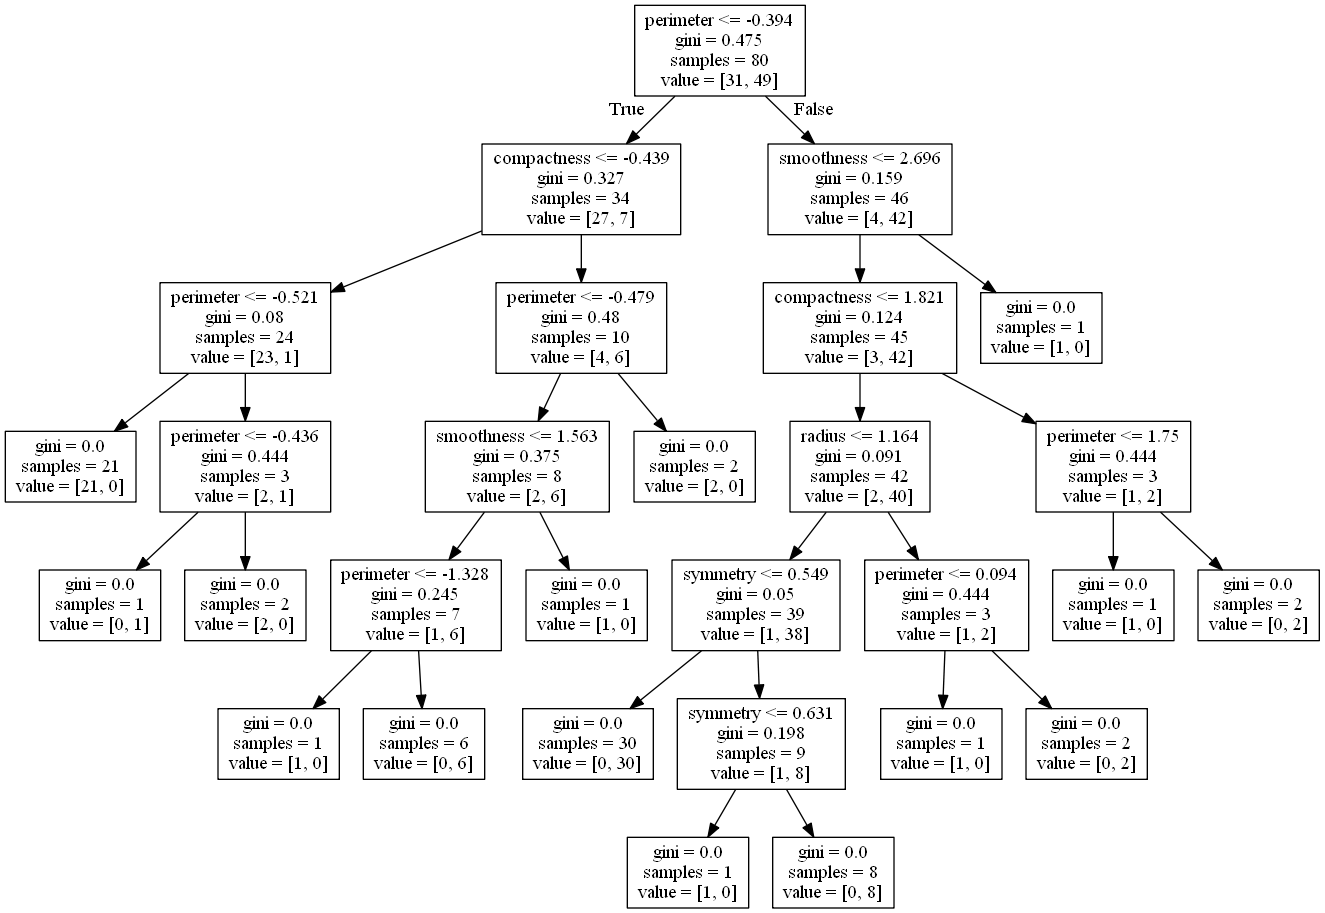

In [20]:
# Display the resulting decision tree
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn import tree
from pydotplus import graph_from_dot_data 

dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data, feature_names=feature_names)  
graph = graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

In [21]:
# Using test data to measure the accuracy of the decision tree model 
clf.score(testing_inputs, testing_results)

0.75

In [22]:
# Using K-Fold cross validation to measure of your model's accuracy (K=10)
from sklearn.model_selection import cross_val_score

clf = DecisionTreeClassifier(random_state=seed)
cv_scores = cross_val_score(clf, features_scaled, results, cv=10)
cv_scores.mean()

0.761919191919192

In [23]:
# Using RandomForestClassifier 
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10, random_state=seed)
cv_scores = cross_val_score(clf, features_scaled, results, cv=10)
cv_scores.mean()

0.8132323232323232

In [24]:
# SVM
from sklearn import svm

C = 1.0
svc = svm.SVC(kernel='linear', C=C)

cv_scores = cross_val_score(svc, features_scaled, results, cv=10)

cv_scores.mean()

0.8534343434343434

In [25]:
# KNeighborsClassifier
from sklearn import neighbors

clf = neighbors.KNeighborsClassifier(n_neighbors=10)
cv_scores = cross_val_score(clf, features_scaled, results, cv=10)

cv_scores.mean()

0.8091919191919192

In [26]:
# Trying different values of K for KNeighborsClassifier
# Using for loop to run KNN with K values ranging from 1 to 10 
# See if K makes a substantial difference. 

for i in range(1, 20):
    clf = neighbors.KNeighborsClassifier(n_neighbors=i)
    cv_scores = cross_val_score(clf, features_scaled, results, cv=10)
    print (i, cv_scores.mean())
    
# k=18: 0.8603030303030303 is better

1 0.7265656565656566
2 0.6876767676767677
3 0.8098989898989899
4 0.8010101010101011
5 0.8089898989898989
6 0.8010101010101011
7 0.8212121212121211
8 0.8201010101010102
9 0.788989898989899
10 0.8091919191919192
11 0.798080808080808
12 0.8191919191919192
13 0.81010101010101
14 0.8403030303030302
15 0.8191919191919192
16 0.8203030303030303
17 0.8303030303030304
18 0.8303030303030304
19 0.8303030303030304


In [27]:
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB

scaler = preprocessing.MinMaxScaler()
features_minmax = scaler.fit_transform(features)

clf = MultinomialNB()
cv_scores = cross_val_score(clf, features_minmax, results, cv=10)

cv_scores.mean()

0.6206060606060607

In [28]:
#GaussianNB
clf = GaussianNB()
cv_scores = cross_val_score(clf, features_scaled, results, cv=10)
cv_scores.mean()

0.8089898989898991

In [29]:
# Logistic Regression 
clf = LogisticRegression()
cv_scores = cross_val_score(clf, features_scaled, results, cv=10)
cv_scores.mean()

0.8534343434343434

In [30]:
# LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
cv_scores = cross_val_score(clf, features_scaled, results, cv=10)
cv_scores.mean()

0.8534343434343434

In [31]:
# DecisionTreeClassifier: 0.761919191919192
# RandomForestClassifier: 0.8132323232323232
# SVM: 0.8534343434343434
# KNeighborsClassifier, k=18: 0.8303030303030304
# Naive Bayes: 0.6206060606060607
# GaussianNB: 0.8089898989898991
# Logistic Regression: 0.8534343434343434
# LinearDiscriminantAnalysis: 0.8534343434343434

# The best algorithms are SVM, LogisticRegression, and LinearDiscriminantAnalysis

In [32]:
# Will use SVM
svm = svm.SVC(kernel='linear', C=C)

svm.fit(training_inputs, training_results)
predictions = svm.predict(testing_inputs)
print("Accuracy:")
print(accuracy_score(testing_results, predictions))
print()
print("Confusion matrix:")
print(confusion_matrix(testing_results, predictions))
print()
print("Classification report:")
print(classification_report(testing_results, predictions))

Accuracy:
0.85

Confusion matrix:
[[ 5  2]
 [ 1 12]]

Classification report:
             precision    recall  f1-score   support

          0       0.83      0.71      0.77         7
          1       0.86      0.92      0.89        13

avg / total       0.85      0.85      0.85        20



In [34]:
import pickle

pickle.dump(svm, open('models//trained_prostate_cancer_model.pkl', 'wb'))

In [35]:
svm_model = pickle.load(open('models//trained_prostate_cancer_model.pkl', 'rb'))

svm_model

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [36]:
print(classification_report(testing_results, svm_model.predict(testing_inputs)))
# To prove that it is the same model that was saved (dumped) and loaded

             precision    recall  f1-score   support

          0       0.83      0.71      0.77         7
          1       0.86      0.92      0.89        13

avg / total       0.85      0.85      0.85        20



In [37]:
# Inputs
# -- radius: radius of the nodule
# -- perimeter: what is the perimeter of the prostate
# -- smoothness: how smooth is the prostate
# -- compactness: how compact is the prostate
# -- symmetry: how symmetrical is the prostate 

# 1: 14.0, 120.0, 1033.0, 0.149, 0.209
# 0: 20.0, 78.0, 0.10300000000000001, 0.091, 0.168

radius = 20.0
perimeter = 78.0
smoothness = 0.103000000001
compactness = 0.091
symmetry = 0.168

# diagnosis_result: the predicted attribute -- diagnosis of prostate cancer 
# -- 0 (benign): No/Low chance of prostate cancer
# -- 1 (malignant): Have/High chance of prostate cancer

# Use the same scaler factors on the new data
scaler = preprocessing.StandardScaler()
features_scaled = scaler.fit_transform(features)

# features_scaled = scaler.transform(features)
data = np.array([[radius, perimeter, smoothness, compactness, symmetry]])
data_scaled = scaler.transform(data)
data_scaled

array([[ 0.64886417, -0.79720137,  0.01853332, -0.5868132 , -0.82172403]])

In [38]:
# Make a prediction against prediction features
prediction = svm_model.predict(data_scaled)
print(prediction)

if prediction == 0:
    print("Low chance of prostate cancer")
elif prediction == 1:
    print("High chance of prostate cancer")
else:
    print("Unable to make a prediction")

[0]
Low chance of prostate cancer
